<a href="https://colab.research.google.com/github/kelvinmw1/Telco_customer_churn/blob/main/customer_churn_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
#First import all the libraries required

!pip install shap
!pip install xgboost
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

In [118]:
#load the dataset

df = pd.read_csv('/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv')

#show a quick preview of the dataset

df.head()
# df.info()
# df.describe()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [119]:
#lets us handle missing values

df.isnull().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [120]:
#let us now encode the categorical variables, the yes/no into binary

le = LabelEncoder()

categorical_columnss = ['gender','Partner','Dependents','PhoneService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Churn']
for col in categorical_columnss:
  df[col] = le.fit_transform(df[col])

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   int64  
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   int64  
 4   Dependents        7043 non-null   int64  
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   int64  
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   int64  
 10  OnlineBackup      7043 non-null   int64  
 11  DeviceProtection  7043 non-null   int64  
 12  TechSupport       7043 non-null   int64  
 13  StreamingTV       7043 non-null   int64  
 14  StreamingMovies   7043 non-null   int64  
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   int64  


In [121]:
#let us now get the average transaction value
#seems like there are empty strings and missing values

df['TotalCharges'] = df['TotalCharges'].replace(' ','0').replace('',0)
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['Avg_Transaction_Value'] = df['TotalCharges'] / df['tenure']

#let us get the transaction frequency of the customer
df['transaction_frequency'] = df['TotalCharges'].count()
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,Avg_Transaction_Value,transaction_frequency
0,7590-VHVEG,0,0,1,0,1,0,No phone service,DSL,0,...,0,0,Month-to-month,1,Electronic check,29.85,29.85,0,29.850000,7043
1,5575-GNVDE,1,0,0,0,34,1,No,DSL,2,...,0,0,One year,0,Mailed check,56.95,1889.50,0,55.573529,7043
2,3668-QPYBK,1,0,0,0,2,1,No,DSL,2,...,0,0,Month-to-month,1,Mailed check,53.85,108.15,1,54.075000,7043
3,7795-CFOCW,1,0,0,0,45,0,No phone service,DSL,2,...,0,0,One year,0,Bank transfer (automatic),42.30,1840.75,0,40.905556,7043
4,9237-HQITU,0,0,0,0,2,1,No,Fiber optic,0,...,0,0,Month-to-month,1,Electronic check,70.70,151.65,1,75.825000,7043


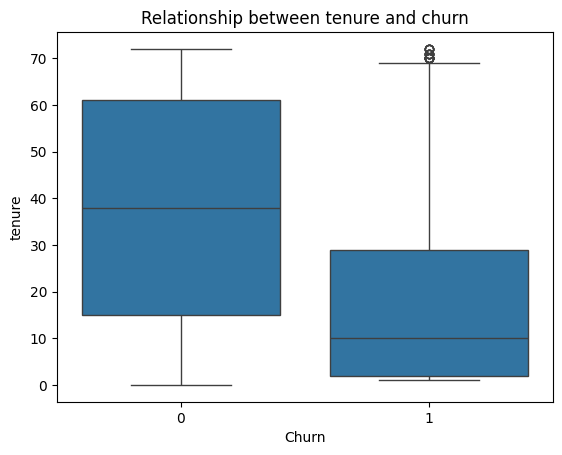

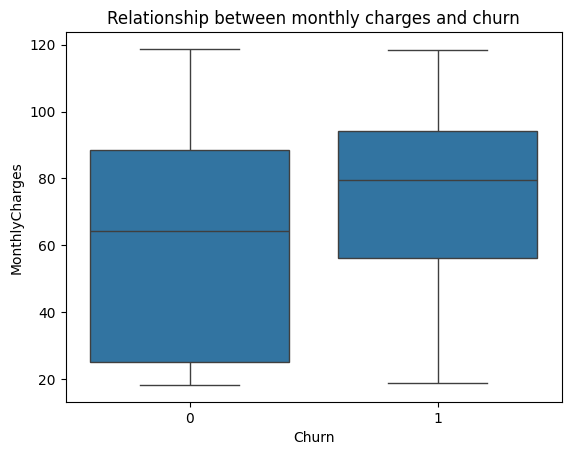

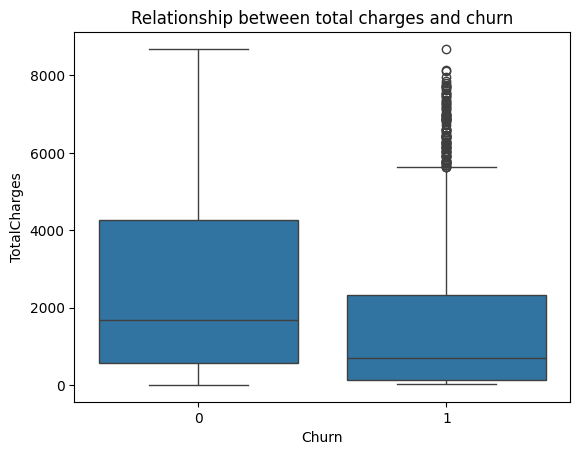

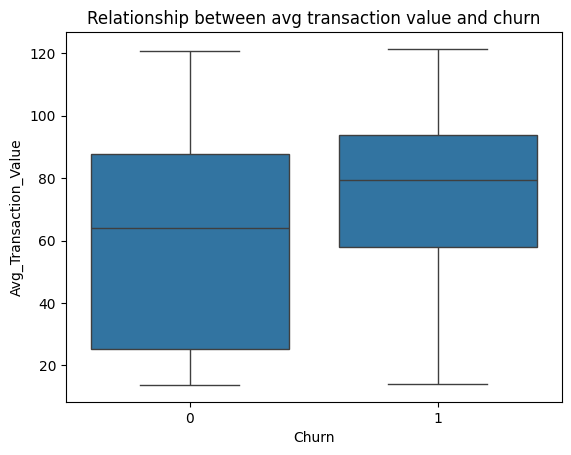

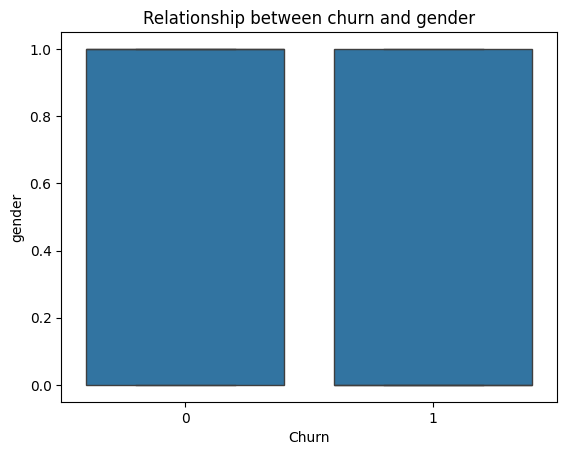

In [122]:
#some EDA to identify factors contributing to churn

df.describe()

#relationship between the tenure and churn
sns.boxplot(x = 'Churn', y='tenure' , data=df)
plt.title('Relationship between tenure and churn')
plt.show()

#relationship between the monthly charges and churn
sns.boxplot(x = 'Churn', y='MonthlyCharges' , data=df)
plt.title('Relationship between monthly charges and churn')
plt.show()

#relationship between the total charges and churn
sns.boxplot(x = 'Churn', y='TotalCharges' , data=df)
plt.title('Relationship between total charges and churn')
plt.show()

#relationship between the avg transaction value and churn
sns.boxplot(x = 'Churn', y='Avg_Transaction_Value' , data=df)
plt.title('Relationship between avg transaction value and churn')
plt.show()

#relationship between churn and gender
sns.boxplot(x='Churn', y='gender', data=df)
plt.title('Relationship between churn and gender')
plt.show()





(0.0, 9129.774683326219)

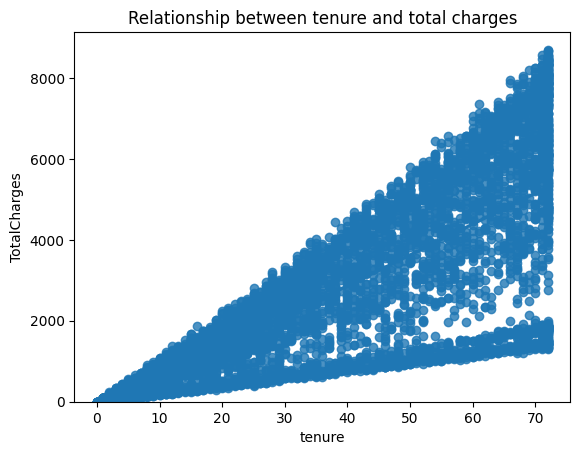

In [123]:
sns.regplot(x='tenure', y='TotalCharges', data=df)
plt.title('Relationship between tenure and total charges')
plt.ylim(0,)


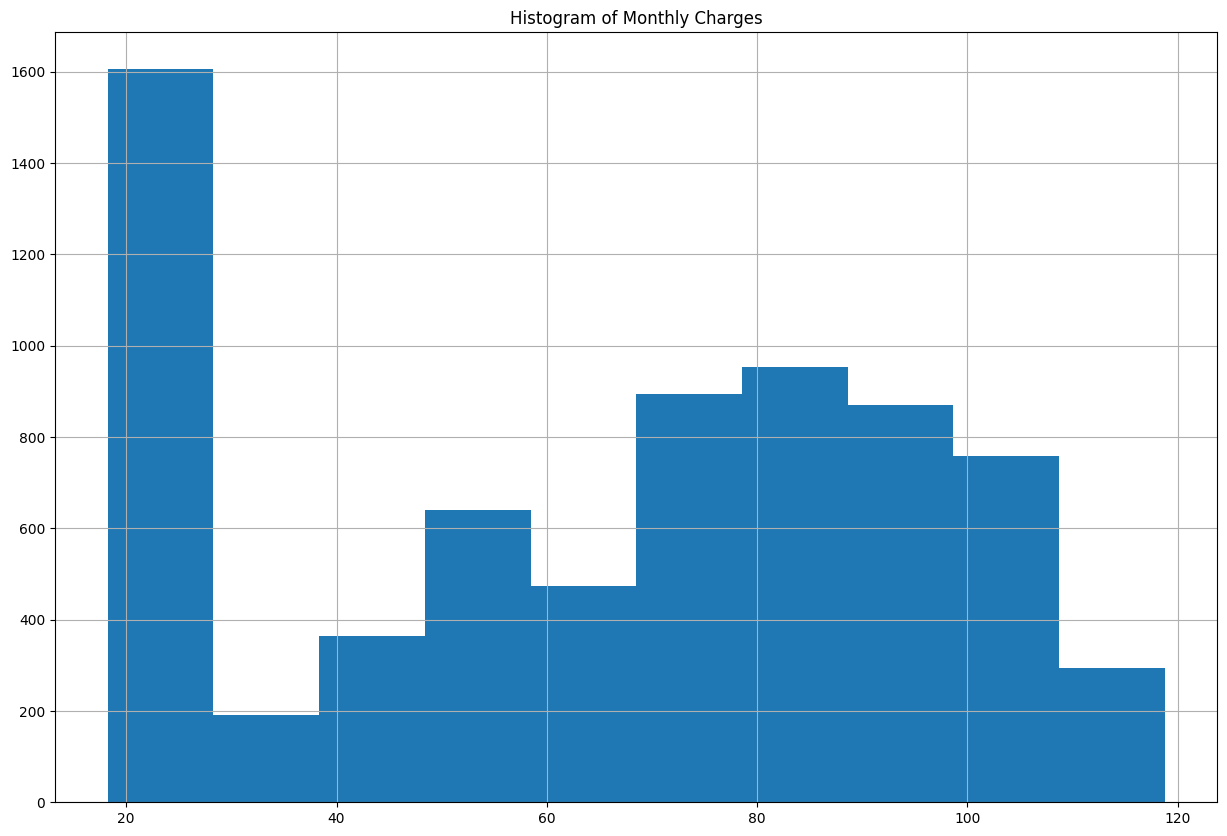

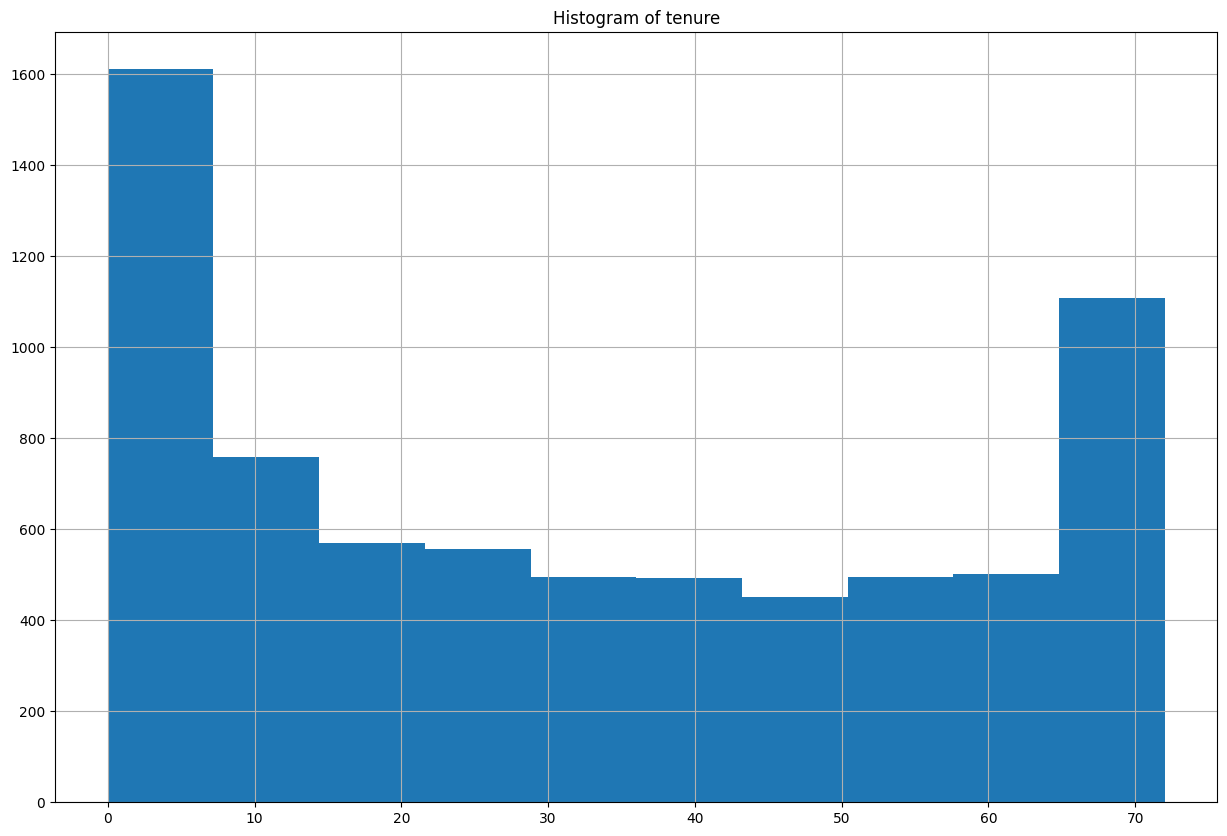

In [124]:
#let us look at a histogram

df.hist(column = 'MonthlyCharges', figsize=(15,10))
plt.title('Histogram of Monthly Charges')
plt.show()

df.hist(column = 'tenure', figsize=(15,10))
plt.title('Histogram of tenure')
plt.show()



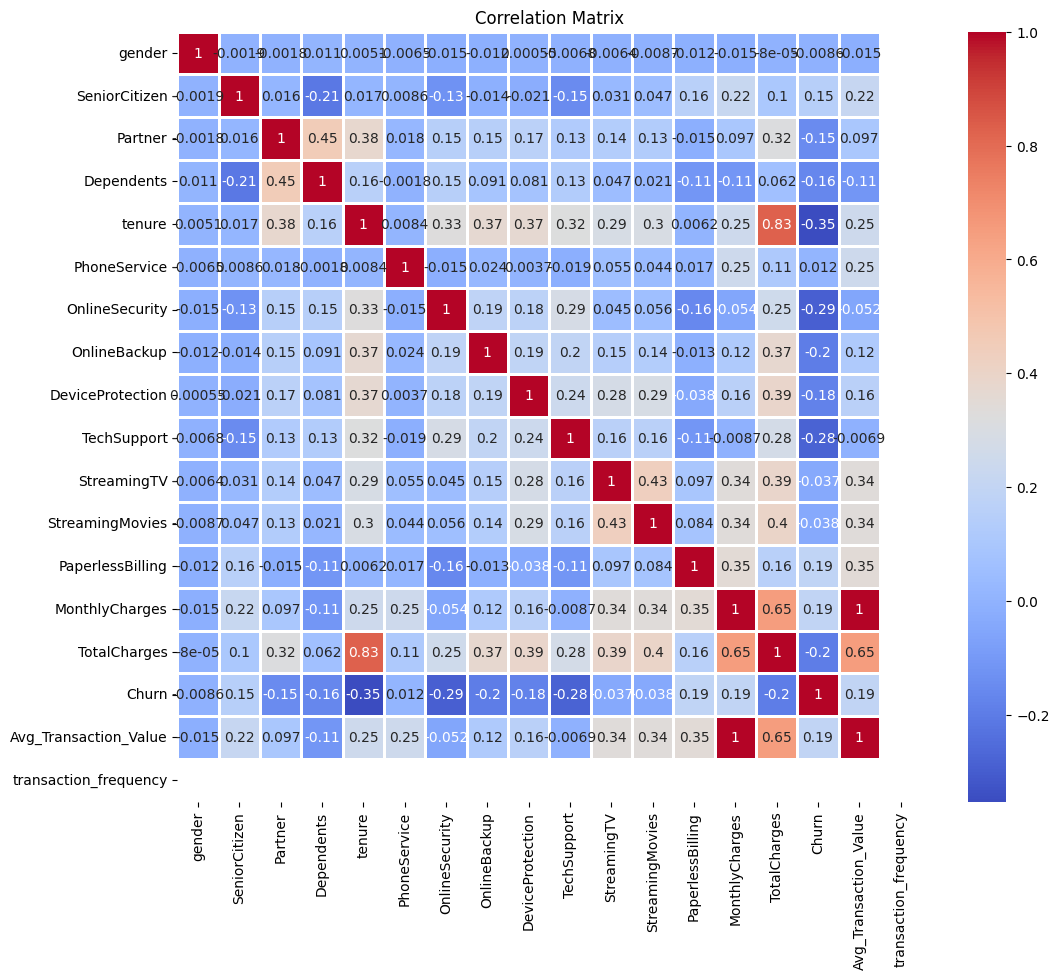

In [125]:
#let us look at the correlation
#use only float and int datatypes
# df_numeric = df_numeric.drop(columns=['customerID'])

df_numeric = df.select_dtypes(include=['float64', 'int64'])


#calculate the correlation matrix

plt.figure(figsize=(12,10))
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.8)
plt.title('Correlation Matrix')
plt.show()


In [126]:
#time to train the models now
#split the data first

x = df.drop(columns=['customerID','Churn','MultipleLines','InternetService','Contract','PaymentMethod'])
y = df['Churn']

df['Churn'] = df['Churn'].astype(float)

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

#impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
x_train = imputer.fit_transform(x_train)
x_test = imputer.transform(x_test)

#a function for all the models we are to use

models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Neural Network': MLPClassifier(),
}

# #train the models

for model_name, model in models.items():

  start_time = time.time()
  model.fit(x_train, y_train)
  end_time = time.time()
  training_time = end_time - start_time
  print(f'{model_name} Training Time: {training_time:.2f} seconds')
  y_pred = model.predict(x_test)
  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  print(f'{model_name} Accuracy: {accuracy:.2f}')
  print(f'{model_name} Precision: {precision:.2f}')
  print(f'{model_name} Recall: {recall:.2f}')
  print(f'{model_name} F1 Score: {f1:.2f}')
  print(f'{model_name} AUC: {auc:.2f}')

print()




Logistic Regression Training Time: 0.08 seconds
Logistic Regression Accuracy: 0.81
Logistic Regression Precision: 0.67
Logistic Regression Recall: 0.54
Logistic Regression F1 Score: 0.60
Logistic Regression AUC: 0.72
Random Forest Training Time: 1.05 seconds
Random Forest Accuracy: 0.80
Random Forest Precision: 0.67
Random Forest Recall: 0.48
Random Forest F1 Score: 0.56
Random Forest AUC: 0.70
Gradient Boosting Training Time: 1.52 seconds
Gradient Boosting Accuracy: 0.80
Gradient Boosting Precision: 0.67
Gradient Boosting Recall: 0.51
Gradient Boosting F1 Score: 0.58
Gradient Boosting AUC: 0.71
Neural Network Training Time: 1.76 seconds
Neural Network Accuracy: 0.68
Neural Network Precision: 0.45
Neural Network Recall: 0.80
Neural Network F1 Score: 0.57
Neural Network AUC: 0.72

